In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import log2
from collections import Counter
import copy
import matplotlib.pylab as plt
%config InlineBackend.figure_format = "svg"

## 画图

In [78]:
#用来正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

def getNumLeafs(myTree):
    #初始化树的叶子节点的个数
    numLeafs = 0
    #myTree.keys()获取树的非叶子节点’no surfacing'和‘flippers’
    #list(mytree.keys()[0]获取第一个键名‘no surfacing’
    firstStr = list(myTree.keys())[0]
    #通过键名获取与之对应的值，即{0:'no',1:{'flippers':{0:'no,1:'yes'}}}
    secondDict = myTree[firstStr]
    #遍历树，secondDict.keys()获取所有的键
    for key in secondDict.keys():
        #判断键是否为字典，键名1和其值就组成了一个字典，如果是字典则通过递归继续遍历，寻找叶子节点
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        #如果不是字典，则叶子节点的数目就加1
        else:
            numLeafs += 1
        #返回叶子节点的数目
    return numLeafs

def getTreeDepth(mytree):
    #初始化树的深度
    maxDepth = 0
    #获取树的第一个键名
    firstStr = list(mytree.keys())[0]
    #获取键名所对应的值
    secondDict = mytree[firstStr]
    #遍历树
    for key in secondDict.keys():
        #如果获取的键是字典，树的深度加一
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1+ getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        #去深度最大值
        if thisDepth > maxDepth : maxDepth = thisDepth
    #返回树的深度
    return maxDepth

#设置画节点用的盒子的样式
decisionNode = dict(boxstyle = 'sawtooth', fc='0.8')
leafNode = dict(boxstyle = 'round4', fc = '0.8')

#设置画箭头的样式
arrow_args = dict(arrowstyle="<-")
#绘图相关参数的设置
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    #annotate函数是为绘制图上指定的数据点xy添加一个nodeTxt注释
    #nodeTxt是给数据点xy添加一个注释，xy为数据点的开始绘制的坐标,位于节点的中间位置
    #xycoords设置指定点xy的坐标类型，xytext为注释的中间点坐标，textcoords设置注释点坐标样式
    #bbox设置装注释盒子的样式,arrowprops设置箭头的样式
    '''
        figure points:表示坐标原点在图的左下角的数据点
        figure pixels:表示坐标原点在图的左下角的像素点
        figure fraction：此时取值是小数，范围是([0,1],[0,1]),在图的左下角时xy是（0,0），最右上角是(1,1)
        其他位置是按相对图的宽高的比例取最小值
        axes points : 表示坐标原点在图中坐标的左下角的数据点
        axes pixels : 表示坐标原点在图中坐标的左下角的像素点
        axes fraction : 与figure fraction类似，只不过相对于图的位置改成是相对于坐标轴的位置
    '''
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
                            xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

#绘制线中间的文字（0和1）的绘制
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

#绘制树
def plotTree(myTree, parentPt, nodeTxt):
    #获取树的叶子节点
    numLeafs = getNumLeafs(myTree)
    #获取树的深度
    depth = getTreeDepth(myTree)
    #firstStr = mytree.keys()[0]
    #获取第一个键名
    firstStr = list(myTree.keys())[0]
    # 计算子节点的坐标
    cntrPt = (plotTree.xoff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yoff)
    # 绘制线上的文字
    plotMidText(cntrPt, parentPt, nodeTxt)
    # 绘制节点
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    # 获取第一个键值
    secondDict = myTree[firstStr]
    # 计算节点y方向上的偏移量，根据树的深度
    plotTree.yoff = plotTree.yoff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 递归绘制树
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            # 更新x的偏移量,每个叶子结点x轴方向上的距离为 1/plotTree.totalW
            plotTree.xoff = plotTree.xoff + 1.0 / plotTree.totalW
            # 绘制非叶子节点
            plotNode(secondDict[key], (plotTree.xoff, plotTree.yoff), cntrPt, leafNode)
            # 绘制箭头上的标志
            plotMidText((plotTree.xoff, plotTree.yoff), cntrPt, str(key))
    plotTree.yoff = plotTree.yoff + 1.0 / plotTree.totalD

#绘制决策树，inTree的格式为{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
def createPlot(inTree):
    #新建一个figure设置背景颜色为白色
    fig = plt.figure(1,facecolor='white')
    #清除figure
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    #创建一个1行1列1个figure，并把网格里面的第一个figure的Axes实例返回给ax1作为函数createPlot()
    #的属性，这个属性ax1相当于一个全局变量，可以给plotNode函数使用
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    #获取树的叶子节点
    plotTree.totalW = float(getNumLeafs(inTree))
    #获取树的深度
    plotTree.totalD = float(getTreeDepth(inTree))
    #节点的x轴的偏移量为-1/plotTree.totlaW/2,1为x轴的长度，除以2保证每一个节点的x轴之间的距离为1/plotTree.totlaW*2
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()
#     plt.savefig("DecisionTree.svg", dpi=300,format="svg")

# C4.5

In [3]:
def calcShannonEnt(dataset):
    """
    计算给定数据集的香农熵
    :param dataset: 数据集
    :return: 香农熵
    """
    count = Counter(dataset[:,-1]) # 获取各类别以及对应的数量
    values = np.array(list(count.values()))/len(dataset) 
    return -np.sum(values*np.log2(values))

In [4]:
def splitDataSet(dataset, axis):
    """
    将数据集按照指定的列根据不同的属性值划分数据集
    :param dataset: 数据集
    :param axis: 列标号
    :return: 属性取值列表，划分后的数据集(二维数组)，
    """
    featureList = set(dataset[:,axis])
    resultDataset = []
    for feature in featureList:
        filterList = dataset[dataset[:,axis] == feature,:] # 过滤出第axis+1维属性等于feature的行
        reduceList = np.concatenate((filterList[:,: axis],filterList[:,axis+1 :]),axis=1)
        resultDataset.append(reduceList)
    return list(featureList),resultDataset

In [19]:
def chooseBestFeatureToSplit(dataset, eps):
    """
    选择划分后信息增益率最大的列
    :param dataset: 数据集
    :param eps: 阈值
    :return: 如果划分后的最大信息增益率不大于eps，则返回-1.否则返回列标号
    """
    baseEntropy = calcShannonEnt(dataset)
    infoGain_list = []
    for i in range(len(dataset[0])-1):
        _, split_dataset = splitDataSet(dataset,i)
        newEntropy = 0.0
        splitEntropy = 0.0
        for subset in split_dataset:
            ratio = len(subset)/len(dataset)
            newEntropy += ratio * calcShannonEnt(subset)
            splitEntropy -= ratio * log2(ratio)
        # 分母加上1e-9是为了防止分母为0
        infoGain_list.append((baseEntropy - newEntropy)/(splitEntropy+1e-9))
    maxInfoGainIndex = np.argmax(infoGain_list)
    return maxInfoGainIndex if infoGain_list[maxInfoGainIndex] >= eps else -1

In [7]:
def majorityCnt(class_list):
    """
    :param class_list: 列表
    :return: 返回列表中出现次数最多的某个值
    """
    # 统计各个特征的出现次数，按降序排序
    count = sorted(Counter(class_list).items(),key = lambda x: x[1], reverse=True)
    return count[0][0]

In [28]:
def createTree(dataset, labels, stopCount, eps):
    """
    :param dataset: 数据集
    :param labels: 标签
    :param stopCount: 数据集中样本数的阈值
    :param eps: 信息增益率的阈值
    :return: 在数据集上使用C4.5算法后生成的树.本质为字典
    """
    class_list = dataset[:,-1]
    # 数据集中所有样本均属于同一类
    if len(set(class_list)) == 1:
        return class_list[0]
    # 无法进行数据划分或者数据集样本数量不大于阈值，停止生长，采用众数投票原则返回列标签
    if len(dataset[0]) == 1 or len(dataset) <= stopCount:
        return majorityCnt(class_list)
    # 选择最佳划分特征
    bestFeat = chooseBestFeatureToSplit(dataset, eps)
    # bestFeat为-1时，表示划分后的最大信息增益率小于阈值，停止生成，采用众数投票原则返回列标签
    if bestFeat == -1:
        return majorityCnt(class_list)
    # 最佳划分特征对应的标签
    bestFeatlabel = labels[bestFeat]
    # 递归建树
    myTree = {bestFeatlabel:{}}
    del(labels[bestFeat])
    splitedFeat,splitedDataSet = splitDataSet(dataset,bestFeat)
    for i, values in enumerate(splitedFeat):
        subLabels = labels[:]
        myTree[bestFeatlabel][values] = createTree(splitedDataSet[i],subLabels,stopCount,eps)
    return myTree

In [46]:
#C4.5剪枝
import copy

def isTree(obj):#判断当前节点是否是叶节点
    return (type(obj).__name__ == 'dict')

def prune(tree, testData, featList):
    newTree = copy.deepcopy(tree)
    firstFeat = list(tree.keys())[0]
    secondDict = tree[firstFeat]
    #print firstFeat
    for key in secondDict.keys():
        #print key
        if isTree(secondDict[key]):
            featNum = featList.index(firstFeat)
            subSample = splitDataSet(testData, featNum, key)
            subclassList = [dataVec[-1] for dataVec in subSample]
            if len(subclassList)!=0:
                if len(subclassList) == subclassList.count(subclassList[0]):
                    tree[firstFeat][key] = majorityCnt(subclassList)
                else:
                    newTree[firstFeat][key] = majorityCnt(subclassList)
                    precison_old = precisionCal(tree, featList, testData)
                    precision_new = precisionCal(newTree, featList, testData)
                    if precision_new > precison_old:
                        tree[firstFeat][key] = majorityCnt(subclassList)
                    else:
                        newfeatList = featList[:featNum] + featList[featNum + 1:]
                        tree[firstFeat][key] = prune(secondDict[key], subSample, newfeatList)
            else:
                continue
    return tree  

In [54]:
import random
def load_data_and_split(data_path='./nursery.data', val_rate=0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表
    """
    with open('./nursery.data','r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    val_lines = random.sample(data_lines,k=int(len(data_lines)*0.2))
    train_data = np.array([])
    val_data = np.array([])
    for data_line in data_lines:
        if data_line in val_lines:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                val_data = np.append(val_data,data_line)
        else:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                train_data = np.append(train_data,data_line)
    return train_data.reshape(-1,9),val_data.reshape(-1,9)

In [96]:
train_data, val_data = load_data_and_split()

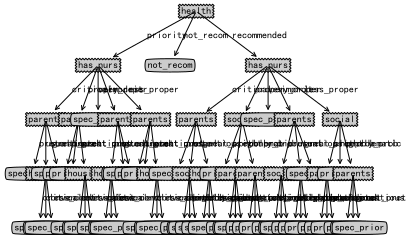

0.910791783199835
0.910073330759973


In [80]:
labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
DT = createTree(train_data,labels[:],eps=0.1, stopCount = 200)
createPlot(DT) # 树结构可视化
print(getCurracy(DT,labels,train_data))
print(getCurracy(DT,labels,val_data))

In [60]:
train_data, val_data = load_data_and_split() #获取训练集和验证集，验证集比例默认20%
labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
DT = createTree(train_data,labels[:],eps=0.1, stopCount = 50) #建树
print(getCurracy(DT,labels,train_data)) #训练集中的准确率
print(getCurracy(DT,labels,val_data)) #验证集中的准确率

0.9288194444443548
0.9220679012342121


In [72]:
# 进行多次测试
def testMultiTimes(times):
    train_acc_list, val_acc_list = [],[]
    time_list = [i+1 for i in range(times)]
    for i in range(times):
        train_data, val_data = load_data_and_split() #获取训练集和验证集，验证集比例默认20%
        labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
        DT = createTree(train_data,labels[:],eps=0.1, stopCount = 100) #建树
        train_acc_list.append(round(getCurracy(DT,labels,train_data)*100,3) # 百分制，且保留三位小数
        val_acc_list.append(round(getCurracy(DT,labels,val_data)*100,3))
    return time_list,train_acc_list,val_acc_list

In [81]:
# 结果可视化
time_list,train_acc_list, val_acc_list = testMultiTimes(10)
fig, aix = plt.subplots()
aix.plot(time_list,train_acc_list,label = 'train_acc') # 训练集折线图
plt.xticks(time_list) # 设置x轴刻度
plt.xlabel("times") # 设置x轴标签
plt.ylabel("accuracy(%)") # 设置y轴标签 
# 将数字标记在折线上方
for a, b in zip(time_list, train_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.plot(time_list,val_acc_list,label = 'validate_acc') # 验证集折线图
# 将数字标记在折线上方
for a, b in zip(time_list, val_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
plt.savefig("mutiTimesTest.svg", dpi=300,format="svg") # 保留图片

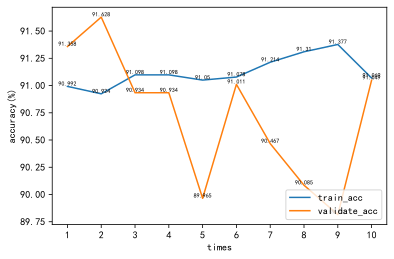

In [75]:
train_list, val_list = [],[]
for acc in train_acc_list:
    train_list.append(round(acc * 100, 3))
for acc in val_acc_list:
    val_list.append(round(acc * 100, 3))
fig, aix = plt.subplots()
aix.plot(time_list,train_list,label='train_acc') # 训练集折线图
plt.xticks(time_list) # 设置x轴刻度
plt.xlabel("times") # 设置x轴标签
plt.ylabel("accuracy(%)") # 设置y轴标签 
# 将数字标记在折线上方
for a, b in zip(time_list, train_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.plot(time_list,val_list,label='validate_acc') # 验证集折线图
aix.legend(loc=4) # 添加图例
# 将数字标记在折线上方
for a, b in zip(time_list, val_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
plt.savefig("mutiTimesTest.svg", dpi=300,format="svg") # 保留图片

In [98]:
#参数调整
def modifyStopCount(lower_bound, upper_bound, step):
    """
    调整参数stopCount,也即样本数量阈值。
    其取值范围为[lower_bound, upper_bound],步长为step
    """
    train_acc_list, val_acc_list = [],[]
    stop_count_list = [i for i in range(lower_bound,upper_bound+1,step)]
    for stop_count in stop_count_list:
        labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
        DT = createTree(train_data,labels[:],eps=0.1, stopCount = stop_count) #建树
        train_acc_list.append(round(getCurracy(DT,labels,train_data)*100,3)) # 百分制，且保留三位小数
        val_acc_list.append(round(getCurracy(DT,labels,val_data)*100,3))
    return stop_count_list,train_acc_list,val_acc_list

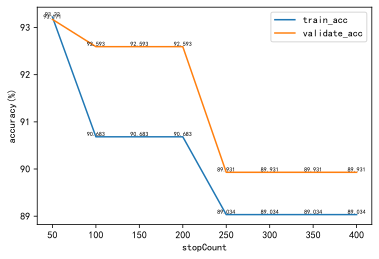

In [100]:
# 结果可视化
stop_count_list,train_acc_list, val_acc_list = modifyStopCount(50,400,50)
fig, aix = plt.subplots()
aix.plot(stop_count_list,train_acc_list,label = 'train_acc') # 训练集折线图
plt.xticks(stop_count_list) # 设置x轴刻度
plt.xlabel("stopCount") # 设置x轴标签
plt.ylabel("accuracy(%)") # 设置y轴标签 
# 将数字标记在折线上方
for a, b in zip(stop_count_list, train_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.plot(stop_count_list,val_acc_list,label = 'validate_acc') # 验证集折线图
# 将数字标记在折线上方
for a, b in zip(stop_count_list, val_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.legend(loc=1) # 添加图例
plt.savefig("modipyStopCount.svg", dpi=300,format="svg") # 保留图片

In [123]:
#参数调整
from time import time
def modifyEps(lower_bound, upper_bound, step):
    """
    调整参数esp,也即信息增益率阈值。
    其取值范围为[lower_bound, upper_bound],步长为step
    """
    train_acc_list, val_acc_list,eps_list = [],[],[]
    eps = lower_bound
    while eps <= upper_bound:
        labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
        DT = createTree(train_data,labels[:],eps=eps, stopCount = 50) #建树
        train_acc_list.append(round(getCurracy(DT,labels,train_data)*100,3)) # 百分制，且保留三位小数
        val_acc_list.append(round(getCurracy(DT,labels,val_data)*100,3))
        eps_list.append(round(eps,2))
        eps += step
    return eps_list,train_acc_list,val_acc_list

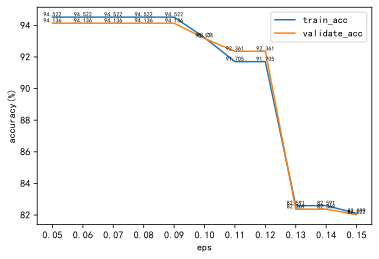

In [125]:
eps_list,train_acc_list,val_acc_list= modifyEps(0.05, 0.15, 0.01)
fig, aix = plt.subplots()
aix.plot(eps_list,train_acc_list,label = 'train_acc') # 训练集折线图
plt.xticks(eps_list) # 设置x轴刻度
plt.xlabel("eps") # 设置x轴标签
plt.ylabel("accuracy(%)") # 设置y轴标签 
# 将数字标记在折线上方
for a, b in zip(eps_list, train_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.plot(eps_list,val_acc_list,label = 'validate_acc') # 验证集折线图
# 将数字标记在折线上方
for a, b in zip(eps_list, val_acc_list):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=6)
aix.legend(loc=1)
plt.savefig("modipyEps.svg", dpi=300,format="svg") # 保留图片

In [ ]:
# 判断当前树的子树是否为全叶子节点
def isLeafNode(tree):
    values = list(tree.values())
    isLeaf = True
    for value in values:
        isLeaf = isLeaf and isinstance(value, dict)
    return isLeaf

def isCut(tree,splitedDataSet,featureList):
    if 

def pruneTree(tree, dataSet, featList):
    if not isinstance(tree,dict):
        return tree
    firstFeat = list(tree.keys())[0]
    secondDict = tree[firstFeat]
    featNum = featList.index(firstFeat)
    featureList,subDataSet = splitDataSet(testData, featNum)
    del(featList[featNum])
    for key in list(secondDict.keys()):
        if key not in featureList:
            continue
        index = featureList.index(key)
        tree[firstFeat][key] = pruneTree(secondDict[key], subDataSet[index], featList[:])
    if isLeafNode(secondDict):
        isCut(secondDict,subDataSet, featureList):
            return majorityCnt(dataSet)
    return tree

In [12]:
def classify(inputTree, featLabels, testVec):
    """
    根据建立好的树，对样本testVec进行预测
    :param inputTree: 调用createTree函数后生成的字典
    :param featLabels: 标签
    :param testVec: 样本向量
    :return: 样本所属的预测标签
    """
    firstStr = list(inputTree.keys())[0]
    # 获取根结点对应的子节点
    secondDict = inputTree[firstStr]
    # 获取根结点名称在标签列表中对应的索引
    featIndex = featLabels.index(firstStr)
    # 由索引获取向量表中的对应值
    key = testVec[featIndex]
    # 获取树干向量后的对象
    if key not in list(secondDict.keys()):
        return "wrong"
    valueOfFeat = secondDict[key]
    # 判断是子结点还是叶子节点：子结点就回调分类函数，叶子结点就是分类结果
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

In [13]:
def getCurracy(inputTree,featLabels,dataSet):
    """
    根据建立好的树，在数据集中进行验证
    :param inputTree: 调用createTree函数后生成的字典
    :param featLabels: 标签
    :param dataSet: 数据集
    :return: 模型预测的准确率
    """
    curr = 0
    for data in dataSet:
        if classify(inputTree,featLabels,data) == data[-1]:
            curr += 1
    return curr/(len(dataSet)+1e-9)

In [237]:
# fr = open('lenses.txt')
# lenses = [inst.strip().split('\t') for inst in fr.readlines()]
# val_data = random.sample(lenses, k=(int)(len(lenses)*0.3))
# train_data = []
# for lense in lenses:
#     if lense not in val_data:
#         train_data.append(lense)

# lenses_labels = ['age', 'prescript','astigmatic','tear_rate']
# train_data,val_data = np.array(train_data), np.array(val_data)
# DT = createDecideTree(train_data,lenses_labels[:])
# tree = copy.deepcopy(DT)
# newDT = prune(tree, val_data, lenses_labels[:])
# createPlot(DT)
# createPlot(newDT)

In [31]:
def E(a,b):
    return a*log2(a) + b*log2(b)

0.4*E(3/4,1/4)+0.6*E(1/6,5/6)

-0.7145247027726656

In [28]:
def G(a,b):
    return 1-a**2-b**2
0.48-0.4*G(3/4,1/4)-0.6*G(1/6,5/6)

0.16333333333333336

['性别', '学生干部', '综合成绩', '毕业论文', '就业情况']


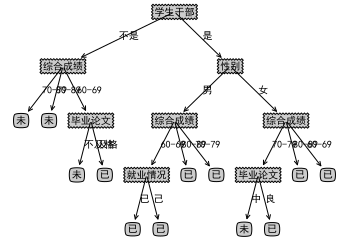

In [146]:
with open('a.txt',encoding='utf-8') as f:
    fr = f.readlines()
tempDataSet = [line.strip('\n') for line in fr]
tempDataSet = np.array(tempDataSet).reshape(-1,6)
labels = list(tempDataSet[0][1 :])
print(labels)
dataSet = tempDataSet[1 :][:,1 :]
# print(dataSet)
tree = createDecideTree(dataSet,labels[:])
createPlot(tree)

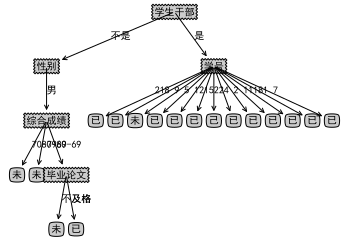

In [73]:
labels = list(tempDataSet[0])
dataSet2 = tempDataSet[1 :]
DT = createDecideTree(dataSet2,labels[:])
createPlot(DT)
# createPlot(newDT)